In [1]:
import matplotlib.pyplot as plt
import os
import sys
path = os.path.abspath('../')  # points to celeste
# if path not in sys.path:
#     sys.path.insert(0, path)
print(path)

import numpy as np
import pytest
import torch

from celeste import device, use_cuda
from celeste import psf_transform
from celeste import train
from celeste import wake
from celeste.datasets import simulated_datasets
from celeste.models import sourcenet
from celeste.datasets.simulated_datasets import get_fitted_powerlaw_psf
from celeste.datasets.galaxy_datasets import DecoderSamples

/home/runingli/astronomy/celeste


In [2]:
torch.manual_seed(60)

In [3]:
test_star = torch.load(os.path.abspath("./..")+"/data/3star_test_params")
test_image = test_star["images"]

FileNotFoundError: [Errno 2] No such file or directory: '/home/runingli/astronomy/celeste/data/3star_test_params'

In [ ]:
plt.imshow(test_image[0,0])
true_locs = test_star["locs"]
locs_x = true_locs[0][:,0].cpu().numpy() * (29)
locs_y = true_locs[0][:,1].cpu().numpy() * (29)
plt.scatter(locs_y, locs_x, marker='x', color='red')

In [4]:
perturb_init_psf = True

In [6]:
# create training dataset
n_bands = 2
max_stars = 20
mean_stars = 10
min_stars = 5
f_min = 1e3
slen = 50

# set background
background = torch.zeros(n_bands, slen, slen, device=device)
background[0] = 686.0
background[1] = 1123.0

## initialize psf params, just add 4 to each sigmas
psf_file = path + "/data/fitted_powerlaw_psf_params.npy"
true_psf_params = torch.from_numpy(np.load(psf_file)).to(device)
print(true_psf_params)
true_psf = get_fitted_powerlaw_psf(psf_file)


init_psf_params = true_psf_params.clone()
if perturb_init_psf: 
    init_psf_params[0, 0] += torch.tensor(1.0).to(device)
    init_psf_params[1, 0] += torch.tensor(1.0).to(device)
    
    init_psf_params[0, 1] += torch.tensor(1.0).to(device)
    init_psf_params[1, 1] += torch.tensor(1.0).to(device)
init_psf = psf_transform.PowerLawPSF(init_psf_params).forward().detach()
print(init_psf_params)

galaxy_slen = 51
galaxy_decoder_file = path + "/data/decoder_params_100_single_band_i.dat"
single_band_galaxy_decoder = DecoderSamples(galaxy_slen, galaxy_decoder_file, n_bands=1)

# simulate dataset
n_images = 128*2
simulator_args = (
    single_band_galaxy_decoder,
    true_psf,
    background,
)

simulator_kwargs = dict(
    slen=slen,
    n_bands=n_bands,
    max_sources=max_stars,
    mean_sources=mean_stars,
    min_sources=min_stars,
    f_min=f_min,
    star_prob=1.0,  # enforce only stars are created in the training images.
)



tensor([[ -0.5396,   1.0622,   3.1312,   1.1505,  -2.1963, -16.2110],
        [ -0.3799,   0.7378,  -0.4502,   3.1473,  -1.2203,  -5.6375]],
       device='cuda:0')
tensor([[  0.4604,   2.0622,   3.1312,   1.1505,  -2.1963, -16.2110],
        [  0.6201,   1.7378,  -0.4502,   3.1473,  -1.2203,  -5.6375]],
       device='cuda:0')


# Run sleep

In [7]:
dataset = simulated_datasets.SourceDataset(
    n_images, simulator_args, simulator_kwargs
)

# setup Star Encoder
star_encoder = sourcenet.SourceEncoder(
    slen=slen,
    ptile_slen=8,
    step=2,
    edge_padding=3,
    n_bands=n_bands,
    max_detections=2,
    n_source_params=n_bands,  # star has n_bands # fluxes
    enc_conv_c=5,
    enc_kern=3,
    enc_hidden=32
).to(device)

# train encoder
# training wrapper
SleepTraining = train.SleepTraining(
    model=star_encoder,
    dataset=dataset,
    slen=slen,
    n_bands=n_bands,
    n_source_params=n_bands,  # star has n_bands # fluxes
    verbose=True,
    batchsize=32,
)

n_epochs = 150 if use_cuda else 1
SleepTraining.run(n_epochs=n_epochs)

/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/celeste/datasets/simulated_datasets.py:365: UserWarning: Remove second part of this assertion once full star&galaxy transition is complete.
  "Remove second part of this assertion once full star&galaxy transition is "
/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/celeste/train.py:234: UserWarning: In transition to full galaxy & star implementation, so only star_prob==1 and star_prob==0 are supported.
  "In transition to full galaxy & star implementation, so only star_prob==1 "


0 loss: 1.8242; counter loss: 1.0797; locs loss: 0.0379; source_params loss: 0.7066 	 [0.6 seconds]
1 loss: 1.2724; counter loss: 0.9318; locs loss: 0.0365; source_params loss: 0.3041 	 [0.4 seconds]
2 loss: 1.0391; counter loss: 0.8050; locs loss: 0.0338; source_params loss: 0.2003 	 [0.4 seconds]
3 loss: 0.9006; counter loss: 0.6899; locs loss: 0.0317; source_params loss: 0.1791 	 [0.4 seconds]
4 loss: 0.7799; counter loss: 0.5870; locs loss: 0.0281; source_params loss: 0.1648 	 [0.4 seconds]
5 loss: 0.6744; counter loss: 0.4973; locs loss: 0.0251; source_params loss: 0.1519 	 [0.4 seconds]
6 loss: 0.5898; counter loss: 0.4228; locs loss: 0.0205; source_params loss: 0.1464 	 [0.5 seconds]
7 loss: 0.5162; counter loss: 0.3604; locs loss: 0.0171; source_params loss: 0.1387 	 [0.4 seconds]
8 loss: 0.4593; counter loss: 0.3090; locs loss: 0.0144; source_params loss: 0.1359 	 [0.4 seconds]
9 loss: 0.3975; counter loss: 0.2641; locs loss: 0.0107; source_params loss: 0.1227 	 [0.4 seconds]


81 loss: -0.0143; counter loss: 0.0169; locs loss: -0.0489; source_params loss: 0.0177 	 [0.4 seconds]
82 loss: -0.0275; counter loss: 0.0164; locs loss: -0.0522; source_params loss: 0.0083 	 [0.4 seconds]
83 loss: -0.0290; counter loss: 0.0158; locs loss: -0.0519; source_params loss: 0.0071 	 [0.4 seconds]
84 loss: -0.0257; counter loss: 0.0154; locs loss: -0.0494; source_params loss: 0.0082 	 [0.4 seconds]
85 loss: -0.0197; counter loss: 0.0151; locs loss: -0.0516; source_params loss: 0.0168 	 [0.4 seconds]
86 loss: -0.0192; counter loss: 0.0155; locs loss: -0.0522; source_params loss: 0.0175 	 [0.4 seconds]
87 loss: -0.0219; counter loss: 0.0159; locs loss: -0.0485; source_params loss: 0.0106 	 [0.4 seconds]
88 loss: -0.0271; counter loss: 0.0147; locs loss: -0.0506; source_params loss: 0.0089 	 [0.4 seconds]
89 loss: -0.0349; counter loss: 0.0154; locs loss: -0.0531; source_params loss: 0.0029 	 [0.4 seconds]
90 loss: -0.0226; counter loss: 0.0155; locs loss: -0.0512; source_params

# Check sleep

In [8]:
# get the estimated params
est_locs, est_source_params, est_n_sources = star_encoder.sample_encoder(
    test_image.to(device),
    n_samples=1,
    return_map_n_sources=True,
    return_map_source_params=True,
    training=False
)

# test that parameters match.
assert est_n_sources == test_star["n_sources"].to(device)

# locs
true_locs = test_star["locs"].to(device)
true_ind = true_locs.argsort(1)
true_ind = true_ind[0, :, 0]

est_locs = est_locs.to(device)
est_ind = est_locs.to(device).argsort(1)
est_ind = est_ind[0, :, 0]

diff_locs = true_locs[:, true_ind, :] - est_locs[:, est_ind, :]
diff_locs *= test_image.size(-1)
assert diff_locs.abs().max() <= 0.5

# fluxes
true_source_params = test_star["log_fluxes"][:, true_ind,].to(device)
est_source_params = est_source_params[:, est_ind, :].to(device)
diff = true_source_params - est_source_params
assert (diff.abs() <= est_source_params.abs() * 0.10).all()
assert (diff.abs() <= true_source_params.abs() * 0.10).all()

In [9]:
# Initialization
init_background_params = torch.zeros(2, 3, device=device)
init_background_params[0, 0] = 686.0
init_background_params[1, 0] = 1123.0

## make sure test background equals the initialization
init_background = wake.PlanarBackground(init_background_params, 30).forward()
assert torch.all(init_background == test_star["background"].to(device))

## Check out initial residuals

In [10]:
from celeste.wake import ModelParams, get_is_on_from_n_sources

In [11]:
model_params = ModelParams(test_image.to(device), init_psf_params, init_background_params)

In [12]:
locs_sampled, log_fluxes_sampled, n_stars_sampled = star_encoder.sample_encoder(
        test_image.to(device),
        n_samples=1,
        return_map_n_sources=False,
        return_map_source_params=False,
    )[0:3]

max_stars = n_stars_sampled.max()
is_on_array = get_is_on_from_n_sources(n_stars_sampled, max_stars)
is_on_array = is_on_array.unsqueeze(2).float()
fluxes_sampled = log_fluxes_sampled.exp() * is_on_array

recon_mean, loss = model_params.get_loss(
    locs=locs_sampled.detach(),
    fluxes=fluxes_sampled.detach(),
    n_stars=n_stars_sampled.detach(),
)

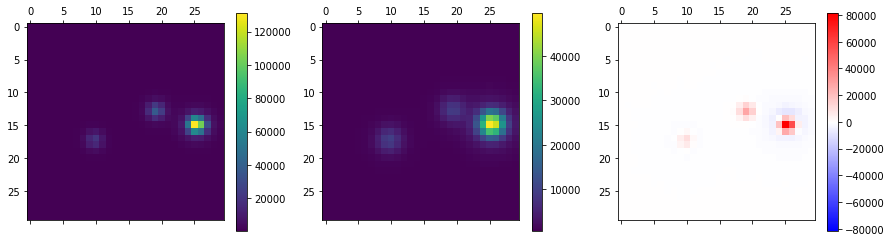

In [13]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))

im0 = axarr[0].matshow(test_image[0, 0].cpu().detach())
fig.colorbar(im0, ax = axarr[0])


im1 = axarr[1].matshow(recon_mean[0, 0].cpu().detach())
fig.colorbar(im1, ax = axarr[1])

resid = test_image[0, 0] - recon_mean[0, 0].cpu().detach() 
im2 = axarr[2].matshow(resid, vmax = resid.abs().max(), vmin = -resid.abs().max(), cmap = plt.get_cmap('bwr'))
fig.colorbar(im2, ax = axarr[2])

# Run wake

In [14]:
true_psf = psf_transform.PowerLawPSF(true_psf_params).forward().detach()
init_psf = psf_transform.PowerLawPSF(init_psf_params).forward().detach()

In [15]:
def compare_psfs(psf1, psf2, fig, axarr, band = 0): 
    
    psf1 = psf1.cpu()[band, 40:60, 40:60]
    psf2 = psf2.cpu()[band, 40:60, 40:60]
    
    vmax = max(psf1.abs().max(), psf2.abs().max())
    print(vmax)
    
    im0 = axarr[0].matshow(psf1, cmap=plt.cm.Blues, vmax = vmax, vmin = 0)
    fig.colorbar(im0, ax = axarr[0])

    im1 = axarr[1].matshow(psf2, cmap=plt.cm.Blues, vmax = None, vmin = 0)
    fig.colorbar(im1, ax = axarr[1])

    psf_resid = (psf1- psf2)
    im2 = axarr[2].matshow(psf_resid, 
                           vmax = psf_resid.abs().max(), vmin = -psf_resid.abs().max(), 
                           cmap = plt.get_cmap('bwr'))
    axarr[2].set_title('Diff')

    fig.colorbar(im2, ax = axarr[2])

tensor(0.1955)


Text(0.5, 1.05, 'Init PSF')

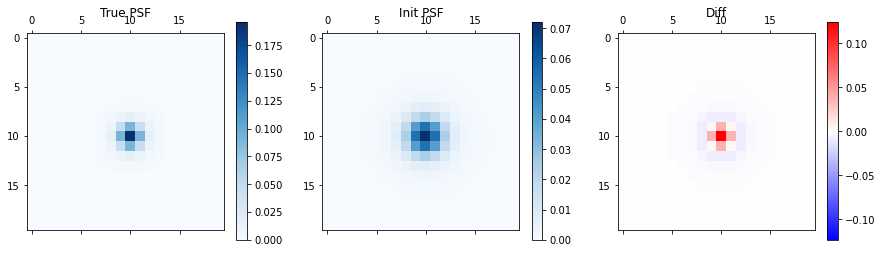

In [16]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))

compare_psfs(true_psf, init_psf, fig, axarr)
axarr[0].set_title('True PSF')
axarr[1].set_title('Init PSF')

In [17]:
# run the wake-phase training
n_epochs = 400 if use_cuda else 1

star_encoder.eval()
estimate_params, map_loss = wake.run_wake(
    test_image.to(device),
    star_encoder,
    init_psf_params,
    init_background_params,
    n_samples=1000,
    n_epochs=n_epochs,
    lr=0.01,
    print_every=10,
    run_map=False,
)

[10] loss: 830108.1875 	[1.0 seconds]
[20] loss: 677506.6250 	[1.0 seconds]
[30] loss: 554476.3750 	[1.0 seconds]
[40] loss: 459295.4062 	[1.0 seconds]
[50] loss: 387217.6562 	[1.1 seconds]
[60] loss: 334614.5312 	[1.1 seconds]
[70] loss: 297752.1562 	[1.0 seconds]
[80] loss: 272925.4375 	[1.1 seconds]
[90] loss: 256692.8125 	[1.0 seconds]
[100] loss: 246544.2500 	[1.0 seconds]
[110] loss: 240354.5469 	[1.0 seconds]
[120] loss: 236710.5625 	[1.0 seconds]
[130] loss: 234675.0000 	[1.0 seconds]
[140] loss: 233610.9375 	[1.0 seconds]
[150] loss: 233078.9688 	[1.0 seconds]
[160] loss: 232850.4688 	[1.0 seconds]
[170] loss: 232777.0781 	[1.0 seconds]
[180] loss: 232745.4688 	[1.1 seconds]
[190] loss: 232714.6875 	[1.0 seconds]
[200] loss: 232678.4844 	[1.0 seconds]
[210] loss: 232654.6719 	[1.0 seconds]
[220] loss: 232637.4062 	[1.0 seconds]
[230] loss: 232625.7031 	[1.0 seconds]
[240] loss: 232611.2969 	[1.0 seconds]
[250] loss: 232595.9531 	[1.0 seconds]
[260] loss: 232582.2188 	[1.0 seco

In [18]:
estimate_psf_params = list(estimate_params.power_law_psf.parameters())[0]
print(true_psf_params)
print(init_psf_params)
print(estimate_psf_params)

tensor([[ -0.5396,   1.0622,   3.1312,   1.1505,  -2.1963, -16.2110],
        [ -0.3799,   0.7378,  -0.4502,   3.1473,  -1.2203,  -5.6375]],
       device='cuda:0')
tensor([[  0.4604,   2.0622,   3.1312,   1.1505,  -2.1963, -16.2110],
        [  0.6201,   1.7378,  -0.4502,   3.1473,  -1.2203,  -5.6375]],
       device='cuda:0')
Parameter containing:
tensor([[ -0.4169,   1.3056,   2.9624,   2.9778,  -2.9474, -15.4065],
        [ -0.1904,   0.8388,  -1.9503,   4.2251,  -2.0227,  -4.3870]],
       device='cuda:0', requires_grad=True)


In [19]:
estimate_psf = psf_transform.PowerLawPSF(estimate_psf_params).forward().detach()
torch.all(estimate_psf >= 0)

tensor(True, device='cuda:0')

tensor(0.1964)


Text(0.5, 1.05, 'Estimated PSF')

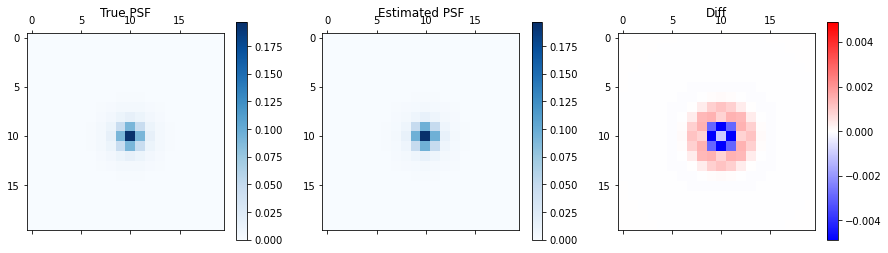

In [20]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))

compare_psfs(true_psf, estimate_psf, fig, axarr)
axarr[0].set_title('True PSF')
axarr[1].set_title('Estimated PSF')

In [21]:
init_residual = (true_psf - init_psf).abs().to(device)
trained_residual = (true_psf - estimate_psf).abs().to(device)
print(trained_residual.sum())
print(init_residual.sum())
assert trained_residual.sum() <= init_residual.sum() * 0.10

tensor(0.1352, device='cuda:0')
tensor(1.2146, device='cuda:0')


AssertionError: 